# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

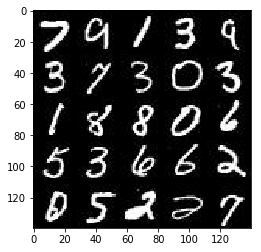

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

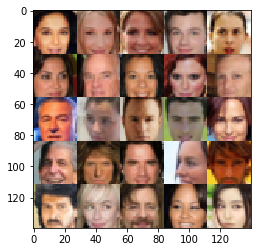

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], 'real_input_images')
    input_z = tf.placeholder(tf.float32, [None, z_dim], 'input_z')
    learning_rate = tf.placeholder(tf.float32, [], 'learning_rate')
    return real_input_images, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xn
        # Convolutional layer, 14x14x64
        conv1 = tf.layers.conv2d(images, 64, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        drop1 = tf.layers.dropout(lrelu1, keep_prob)
        
        # Strided convolutional layer, 7x7x128
        conv2 = tf.layers.conv2d(drop1, 128, 5, 2, 'same', use_bias=False)
        bn2 = tf.layers.batch_normalization(conv2)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.layers.dropout(lrelu2, keep_prob)
        
        # Strided convolutional layer, 4x4x256
        conv3 = tf.layers.conv2d(drop2, 256, 5, 2, 'same', use_bias=False)
        bn3 = tf.layers.batch_normalization(conv3)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.layers.dropout(lrelu3, keep_prob)
        
        # fully connected
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer, 4x4x1024
        fc = tf.layers.dense(z, 4*4*1024, use_bias=False)
        fc = tf.reshape(fc, (-1, 4, 4, 1024))
        bn0 = tf.layers.batch_normalization(fc, training=is_train)
        lrelu0 = tf.maximum(alpha * bn0, bn0)
        drop0 = tf.layers.dropout(lrelu0, keep_prob, training=is_train)
        
        # Deconvolution, 7x7x512
        conv1 = tf.layers.conv2d_transpose(drop0, 512, 4, 1, 'valid', use_bias=False)
        bn1 = tf.layers.batch_normalization(conv1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        drop1 = tf.layers.dropout(lrelu1, keep_prob, training=is_train)
        
        # Deconvolution, 14x14x256
        conv2 = tf.layers.conv2d_transpose(drop1, 256, 5, 2, 'same', use_bias=False)
        bn2 = tf.layers.batch_normalization(conv2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.layers.dropout(lrelu2, keep_prob, training=is_train)
        
        # Output layer, 28x28xn
        logits = tf.layers.conv2d_transpose(drop2, out_channel_dim, 5, 2, 'same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth_factor=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * (1 - smooth_factor)))
    
    input_fake = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(input_fake, reuse=True, alpha=alpha)
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss_real + d_loss_fake, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, steps),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))  

                if steps % show_every == 0:
                    # Show example output for the generator
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode) 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 10... Discriminator Loss: 1.0692... Generator Loss: 0.9518
Epoch 1/2 Step 20... Discriminator Loss: 0.4560... Generator Loss: 2.3037
Epoch 1/2 Step 30... Discriminator Loss: 0.8797... Generator Loss: 1.2622
Epoch 1/2 Step 40... Discriminator Loss: 1.0906... Generator Loss: 0.8460
Epoch 1/2 Step 50... Discriminator Loss: 1.3621... Generator Loss: 0.8222
Epoch 1/2 Step 60... Discriminator Loss: 2.1478... Generator Loss: 0.2695
Epoch 1/2 Step 70... Discriminator Loss: 1.1655... Generator Loss: 0.7466
Epoch 1/2 Step 80... Discriminator Loss: 1.1995... Generator Loss: 0.8961
Epoch 1/2 Step 90... Discriminator Loss: 1.1959... Generator Loss: 0.7957
Epoch 1/2 Step 100... Discriminator Loss: 0.8978... Generator Loss: 1.2825


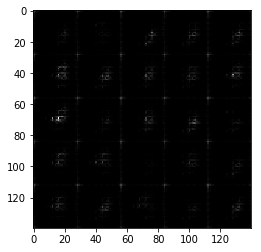

Epoch 1/2 Step 110... Discriminator Loss: 1.1128... Generator Loss: 1.0476
Epoch 1/2 Step 120... Discriminator Loss: 1.3927... Generator Loss: 0.6867
Epoch 1/2 Step 130... Discriminator Loss: 1.0842... Generator Loss: 0.8548
Epoch 1/2 Step 140... Discriminator Loss: 1.2173... Generator Loss: 0.6735
Epoch 1/2 Step 150... Discriminator Loss: 0.8578... Generator Loss: 1.3847
Epoch 1/2 Step 160... Discriminator Loss: 1.4044... Generator Loss: 1.0335
Epoch 1/2 Step 170... Discriminator Loss: 1.4027... Generator Loss: 0.8056
Epoch 1/2 Step 180... Discriminator Loss: 1.3705... Generator Loss: 0.8267
Epoch 1/2 Step 190... Discriminator Loss: 1.4661... Generator Loss: 0.6943
Epoch 1/2 Step 200... Discriminator Loss: 1.1935... Generator Loss: 0.9517


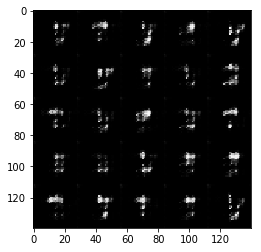

Epoch 1/2 Step 210... Discriminator Loss: 1.1074... Generator Loss: 1.2539
Epoch 1/2 Step 220... Discriminator Loss: 1.3589... Generator Loss: 0.8296
Epoch 1/2 Step 230... Discriminator Loss: 1.2168... Generator Loss: 0.9341
Epoch 1/2 Step 240... Discriminator Loss: 1.3939... Generator Loss: 0.7380
Epoch 1/2 Step 250... Discriminator Loss: 1.3202... Generator Loss: 0.8464
Epoch 1/2 Step 260... Discriminator Loss: 1.4162... Generator Loss: 0.5574
Epoch 1/2 Step 270... Discriminator Loss: 1.2600... Generator Loss: 0.9346
Epoch 1/2 Step 280... Discriminator Loss: 1.4571... Generator Loss: 0.5365
Epoch 1/2 Step 290... Discriminator Loss: 0.8573... Generator Loss: 1.4138
Epoch 1/2 Step 300... Discriminator Loss: 1.4355... Generator Loss: 1.0636


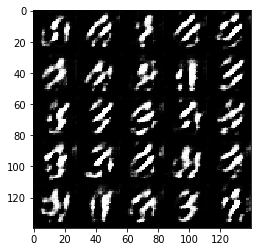

Epoch 1/2 Step 310... Discriminator Loss: 0.7989... Generator Loss: 1.6676
Epoch 1/2 Step 320... Discriminator Loss: 1.1260... Generator Loss: 0.8909
Epoch 1/2 Step 330... Discriminator Loss: 1.4093... Generator Loss: 0.8101
Epoch 1/2 Step 340... Discriminator Loss: 1.3948... Generator Loss: 0.8094
Epoch 1/2 Step 350... Discriminator Loss: 1.1244... Generator Loss: 0.9847
Epoch 1/2 Step 360... Discriminator Loss: 1.2015... Generator Loss: 1.0004
Epoch 1/2 Step 370... Discriminator Loss: 1.3702... Generator Loss: 0.7965
Epoch 1/2 Step 380... Discriminator Loss: 1.2748... Generator Loss: 0.9208
Epoch 1/2 Step 390... Discriminator Loss: 1.2365... Generator Loss: 0.8484
Epoch 1/2 Step 400... Discriminator Loss: 1.2866... Generator Loss: 0.6381


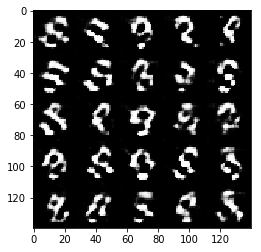

Epoch 1/2 Step 410... Discriminator Loss: 1.1508... Generator Loss: 0.9408
Epoch 1/2 Step 420... Discriminator Loss: 1.0345... Generator Loss: 1.0844
Epoch 1/2 Step 430... Discriminator Loss: 1.2665... Generator Loss: 0.9880
Epoch 1/2 Step 440... Discriminator Loss: 1.2518... Generator Loss: 0.9178
Epoch 1/2 Step 450... Discriminator Loss: 1.1810... Generator Loss: 0.9675
Epoch 1/2 Step 460... Discriminator Loss: 1.2829... Generator Loss: 1.5068
Epoch 1/2 Step 470... Discriminator Loss: 1.1716... Generator Loss: 0.9918
Epoch 1/2 Step 480... Discriminator Loss: 1.2355... Generator Loss: 0.8948
Epoch 1/2 Step 490... Discriminator Loss: 1.2192... Generator Loss: 1.1129
Epoch 1/2 Step 500... Discriminator Loss: 1.2382... Generator Loss: 1.1834


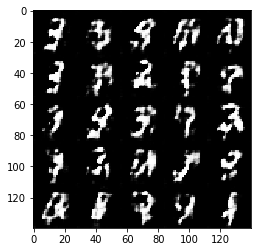

Epoch 1/2 Step 510... Discriminator Loss: 1.1571... Generator Loss: 1.2391
Epoch 1/2 Step 520... Discriminator Loss: 1.0599... Generator Loss: 1.2480
Epoch 1/2 Step 530... Discriminator Loss: 1.4734... Generator Loss: 0.8075
Epoch 1/2 Step 540... Discriminator Loss: 1.0129... Generator Loss: 1.2614
Epoch 1/2 Step 550... Discriminator Loss: 1.2633... Generator Loss: 0.9101
Epoch 1/2 Step 560... Discriminator Loss: 1.2939... Generator Loss: 0.9201
Epoch 1/2 Step 570... Discriminator Loss: 1.0585... Generator Loss: 1.2190
Epoch 1/2 Step 580... Discriminator Loss: 1.0944... Generator Loss: 1.0626
Epoch 1/2 Step 590... Discriminator Loss: 1.3469... Generator Loss: 0.8214
Epoch 1/2 Step 600... Discriminator Loss: 1.1647... Generator Loss: 1.5231


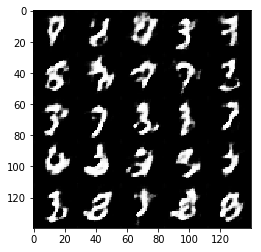

Epoch 1/2 Step 610... Discriminator Loss: 1.1327... Generator Loss: 1.2595
Epoch 1/2 Step 620... Discriminator Loss: 1.1282... Generator Loss: 0.8824
Epoch 1/2 Step 630... Discriminator Loss: 1.2621... Generator Loss: 0.8671
Epoch 1/2 Step 640... Discriminator Loss: 1.2274... Generator Loss: 0.8477
Epoch 1/2 Step 650... Discriminator Loss: 1.1407... Generator Loss: 1.4041
Epoch 1/2 Step 660... Discriminator Loss: 1.0736... Generator Loss: 1.0663
Epoch 1/2 Step 670... Discriminator Loss: 1.2301... Generator Loss: 0.8768
Epoch 1/2 Step 680... Discriminator Loss: 1.2288... Generator Loss: 0.9352
Epoch 1/2 Step 690... Discriminator Loss: 1.2263... Generator Loss: 0.7350
Epoch 1/2 Step 700... Discriminator Loss: 1.2576... Generator Loss: 0.9314


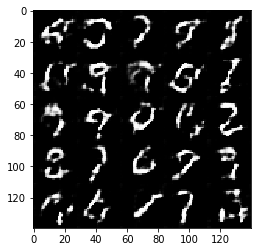

Epoch 1/2 Step 710... Discriminator Loss: 1.3418... Generator Loss: 0.9051
Epoch 1/2 Step 720... Discriminator Loss: 1.1827... Generator Loss: 1.3895
Epoch 1/2 Step 730... Discriminator Loss: 1.0880... Generator Loss: 0.9763
Epoch 1/2 Step 740... Discriminator Loss: 1.3337... Generator Loss: 0.7958
Epoch 1/2 Step 750... Discriminator Loss: 1.0525... Generator Loss: 1.0810
Epoch 1/2 Step 760... Discriminator Loss: 1.2898... Generator Loss: 1.1565
Epoch 1/2 Step 770... Discriminator Loss: 1.3572... Generator Loss: 0.7146
Epoch 1/2 Step 780... Discriminator Loss: 1.1796... Generator Loss: 0.9713
Epoch 1/2 Step 790... Discriminator Loss: 1.3955... Generator Loss: 0.5848
Epoch 1/2 Step 800... Discriminator Loss: 1.2098... Generator Loss: 0.9037


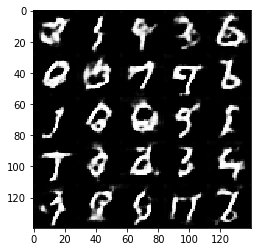

Epoch 1/2 Step 810... Discriminator Loss: 1.2292... Generator Loss: 1.5727
Epoch 1/2 Step 820... Discriminator Loss: 1.1716... Generator Loss: 0.9929
Epoch 1/2 Step 830... Discriminator Loss: 1.2267... Generator Loss: 0.7066
Epoch 1/2 Step 840... Discriminator Loss: 1.1772... Generator Loss: 0.9694
Epoch 1/2 Step 850... Discriminator Loss: 1.1197... Generator Loss: 0.9527
Epoch 1/2 Step 860... Discriminator Loss: 1.3595... Generator Loss: 1.6985
Epoch 1/2 Step 870... Discriminator Loss: 1.2776... Generator Loss: 0.8640
Epoch 1/2 Step 880... Discriminator Loss: 0.9885... Generator Loss: 1.2009
Epoch 1/2 Step 890... Discriminator Loss: 1.1440... Generator Loss: 0.9178
Epoch 1/2 Step 900... Discriminator Loss: 1.3139... Generator Loss: 1.1114


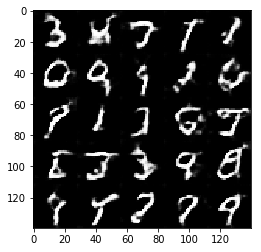

Epoch 1/2 Step 910... Discriminator Loss: 1.1479... Generator Loss: 1.1335
Epoch 1/2 Step 920... Discriminator Loss: 1.2107... Generator Loss: 0.8936
Epoch 1/2 Step 930... Discriminator Loss: 1.1740... Generator Loss: 1.0676
Epoch 2/2 Step 940... Discriminator Loss: 1.1616... Generator Loss: 0.9312
Epoch 2/2 Step 950... Discriminator Loss: 1.3185... Generator Loss: 1.1800
Epoch 2/2 Step 960... Discriminator Loss: 1.2804... Generator Loss: 0.8128
Epoch 2/2 Step 970... Discriminator Loss: 1.0809... Generator Loss: 1.2207
Epoch 2/2 Step 980... Discriminator Loss: 1.1816... Generator Loss: 1.0404
Epoch 2/2 Step 990... Discriminator Loss: 1.2964... Generator Loss: 0.7774
Epoch 2/2 Step 1000... Discriminator Loss: 1.1316... Generator Loss: 0.8805


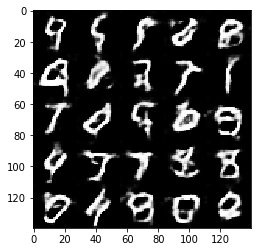

Epoch 2/2 Step 1010... Discriminator Loss: 1.2267... Generator Loss: 0.9923
Epoch 2/2 Step 1020... Discriminator Loss: 1.2158... Generator Loss: 1.0372
Epoch 2/2 Step 1030... Discriminator Loss: 1.1021... Generator Loss: 0.9063
Epoch 2/2 Step 1040... Discriminator Loss: 1.2975... Generator Loss: 0.8845
Epoch 2/2 Step 1050... Discriminator Loss: 1.3032... Generator Loss: 0.5743
Epoch 2/2 Step 1060... Discriminator Loss: 1.1884... Generator Loss: 0.9111
Epoch 2/2 Step 1070... Discriminator Loss: 1.1875... Generator Loss: 0.9423
Epoch 2/2 Step 1080... Discriminator Loss: 1.1215... Generator Loss: 1.0288
Epoch 2/2 Step 1090... Discriminator Loss: 1.1182... Generator Loss: 0.8821
Epoch 2/2 Step 1100... Discriminator Loss: 1.1781... Generator Loss: 0.8666


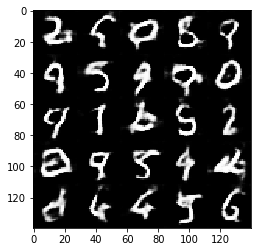

Epoch 2/2 Step 1110... Discriminator Loss: 1.1689... Generator Loss: 0.9475
Epoch 2/2 Step 1120... Discriminator Loss: 1.3181... Generator Loss: 1.0150
Epoch 2/2 Step 1130... Discriminator Loss: 1.2613... Generator Loss: 0.8663
Epoch 2/2 Step 1140... Discriminator Loss: 1.2711... Generator Loss: 0.6241
Epoch 2/2 Step 1150... Discriminator Loss: 1.2786... Generator Loss: 0.8288
Epoch 2/2 Step 1160... Discriminator Loss: 1.1409... Generator Loss: 1.0716
Epoch 2/2 Step 1170... Discriminator Loss: 1.1126... Generator Loss: 1.2437
Epoch 2/2 Step 1180... Discriminator Loss: 1.2924... Generator Loss: 1.3724
Epoch 2/2 Step 1190... Discriminator Loss: 1.1341... Generator Loss: 0.9834
Epoch 2/2 Step 1200... Discriminator Loss: 1.1018... Generator Loss: 1.2297


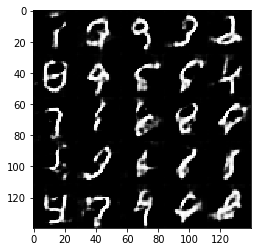

Epoch 2/2 Step 1210... Discriminator Loss: 1.1853... Generator Loss: 1.0393
Epoch 2/2 Step 1220... Discriminator Loss: 1.2937... Generator Loss: 0.7102
Epoch 2/2 Step 1230... Discriminator Loss: 1.2161... Generator Loss: 1.3310
Epoch 2/2 Step 1240... Discriminator Loss: 1.1746... Generator Loss: 0.8362
Epoch 2/2 Step 1250... Discriminator Loss: 1.2070... Generator Loss: 1.0338
Epoch 2/2 Step 1260... Discriminator Loss: 1.2475... Generator Loss: 1.3223
Epoch 2/2 Step 1270... Discriminator Loss: 1.1133... Generator Loss: 0.9768
Epoch 2/2 Step 1280... Discriminator Loss: 1.5855... Generator Loss: 1.5718
Epoch 2/2 Step 1290... Discriminator Loss: 1.1574... Generator Loss: 0.9592
Epoch 2/2 Step 1300... Discriminator Loss: 1.0833... Generator Loss: 1.1214


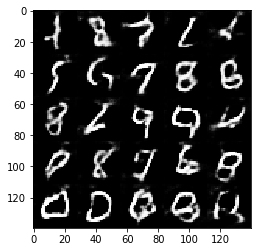

Epoch 2/2 Step 1310... Discriminator Loss: 1.1478... Generator Loss: 1.0646
Epoch 2/2 Step 1320... Discriminator Loss: 1.1352... Generator Loss: 1.1672
Epoch 2/2 Step 1330... Discriminator Loss: 1.0736... Generator Loss: 1.1485
Epoch 2/2 Step 1340... Discriminator Loss: 1.2509... Generator Loss: 1.1363
Epoch 2/2 Step 1350... Discriminator Loss: 1.1786... Generator Loss: 0.8326
Epoch 2/2 Step 1360... Discriminator Loss: 1.1941... Generator Loss: 0.7767
Epoch 2/2 Step 1370... Discriminator Loss: 1.1778... Generator Loss: 0.8971
Epoch 2/2 Step 1380... Discriminator Loss: 1.1457... Generator Loss: 1.2644
Epoch 2/2 Step 1390... Discriminator Loss: 1.1886... Generator Loss: 1.0169
Epoch 2/2 Step 1400... Discriminator Loss: 1.1441... Generator Loss: 1.3331


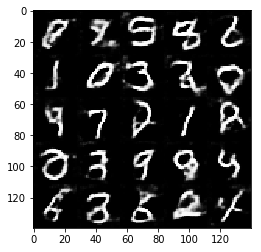

Epoch 2/2 Step 1410... Discriminator Loss: 1.1153... Generator Loss: 1.2615
Epoch 2/2 Step 1420... Discriminator Loss: 1.1083... Generator Loss: 1.0617
Epoch 2/2 Step 1430... Discriminator Loss: 1.1775... Generator Loss: 1.0700
Epoch 2/2 Step 1440... Discriminator Loss: 1.1003... Generator Loss: 0.9826
Epoch 2/2 Step 1450... Discriminator Loss: 1.0303... Generator Loss: 0.9978
Epoch 2/2 Step 1460... Discriminator Loss: 1.1309... Generator Loss: 0.9349
Epoch 2/2 Step 1470... Discriminator Loss: 1.2165... Generator Loss: 0.7088
Epoch 2/2 Step 1480... Discriminator Loss: 1.1478... Generator Loss: 1.0920
Epoch 2/2 Step 1490... Discriminator Loss: 1.2161... Generator Loss: 0.7238
Epoch 2/2 Step 1500... Discriminator Loss: 1.1075... Generator Loss: 0.9603


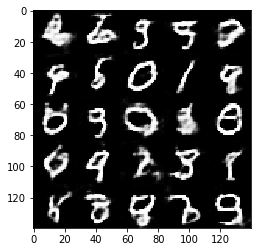

Epoch 2/2 Step 1510... Discriminator Loss: 1.1734... Generator Loss: 1.1446
Epoch 2/2 Step 1520... Discriminator Loss: 1.1573... Generator Loss: 1.3000
Epoch 2/2 Step 1530... Discriminator Loss: 1.1322... Generator Loss: 1.3870
Epoch 2/2 Step 1540... Discriminator Loss: 1.0146... Generator Loss: 0.9859
Epoch 2/2 Step 1550... Discriminator Loss: 1.1407... Generator Loss: 0.7947
Epoch 2/2 Step 1560... Discriminator Loss: 1.1392... Generator Loss: 0.8659
Epoch 2/2 Step 1570... Discriminator Loss: 1.1027... Generator Loss: 1.0406
Epoch 2/2 Step 1580... Discriminator Loss: 1.1189... Generator Loss: 1.2961
Epoch 2/2 Step 1590... Discriminator Loss: 1.0525... Generator Loss: 1.0718
Epoch 2/2 Step 1600... Discriminator Loss: 1.1622... Generator Loss: 1.1562


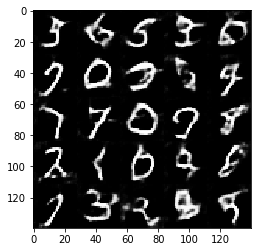

Epoch 2/2 Step 1610... Discriminator Loss: 1.1425... Generator Loss: 1.1513
Epoch 2/2 Step 1620... Discriminator Loss: 1.1144... Generator Loss: 1.1340
Epoch 2/2 Step 1630... Discriminator Loss: 1.1169... Generator Loss: 1.2254
Epoch 2/2 Step 1640... Discriminator Loss: 1.1201... Generator Loss: 1.5034
Epoch 2/2 Step 1650... Discriminator Loss: 1.1053... Generator Loss: 1.0221
Epoch 2/2 Step 1660... Discriminator Loss: 1.1921... Generator Loss: 1.7461
Epoch 2/2 Step 1670... Discriminator Loss: 1.0603... Generator Loss: 0.9622
Epoch 2/2 Step 1680... Discriminator Loss: 1.0485... Generator Loss: 1.2922
Epoch 2/2 Step 1690... Discriminator Loss: 1.1356... Generator Loss: 0.7927
Epoch 2/2 Step 1700... Discriminator Loss: 1.1770... Generator Loss: 1.2315


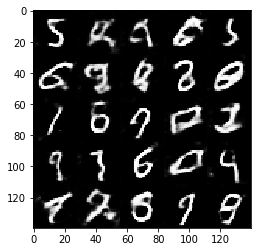

Epoch 2/2 Step 1710... Discriminator Loss: 1.0809... Generator Loss: 1.0370
Epoch 2/2 Step 1720... Discriminator Loss: 1.1623... Generator Loss: 1.2016
Epoch 2/2 Step 1730... Discriminator Loss: 1.0290... Generator Loss: 1.1631
Epoch 2/2 Step 1740... Discriminator Loss: 1.1200... Generator Loss: 0.9212
Epoch 2/2 Step 1750... Discriminator Loss: 1.1146... Generator Loss: 1.2667
Epoch 2/2 Step 1760... Discriminator Loss: 1.0240... Generator Loss: 1.0868
Epoch 2/2 Step 1770... Discriminator Loss: 1.1535... Generator Loss: 0.7882
Epoch 2/2 Step 1780... Discriminator Loss: 1.1269... Generator Loss: 0.9548
Epoch 2/2 Step 1790... Discriminator Loss: 0.9766... Generator Loss: 1.1780
Epoch 2/2 Step 1800... Discriminator Loss: 1.1354... Generator Loss: 1.2359


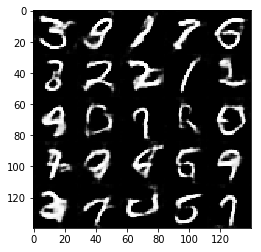

Epoch 2/2 Step 1810... Discriminator Loss: 1.1806... Generator Loss: 1.9289
Epoch 2/2 Step 1820... Discriminator Loss: 1.0378... Generator Loss: 1.0615
Epoch 2/2 Step 1830... Discriminator Loss: 1.0610... Generator Loss: 1.2806
Epoch 2/2 Step 1840... Discriminator Loss: 1.0361... Generator Loss: 1.2190
Epoch 2/2 Step 1850... Discriminator Loss: 1.0135... Generator Loss: 1.2815
Epoch 2/2 Step 1860... Discriminator Loss: 1.0106... Generator Loss: 0.9547
Epoch 2/2 Step 1870... Discriminator Loss: 1.0456... Generator Loss: 1.2820


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.00025
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Step 10... Discriminator Loss: 1.1923... Generator Loss: 1.0619
Epoch 1/1 Step 20... Discriminator Loss: 0.8847... Generator Loss: 1.5612
Epoch 1/1 Step 30... Discriminator Loss: 0.7253... Generator Loss: 2.2552
Epoch 1/1 Step 40... Discriminator Loss: 1.1529... Generator Loss: 0.9782
Epoch 1/1 Step 50... Discriminator Loss: 0.9037... Generator Loss: 1.4947
Epoch 1/1 Step 60... Discriminator Loss: 0.9751... Generator Loss: 1.3517
Epoch 1/1 Step 70... Discriminator Loss: 0.8642... Generator Loss: 1.8543
Epoch 1/1 Step 80... Discriminator Loss: 0.8311... Generator Loss: 2.1904
Epoch 1/1 Step 90... Discriminator Loss: 0.6532... Generator Loss: 1.7231
Epoch 1/1 Step 100... Discriminator Loss: 0.7097... Generator Loss: 1.9396


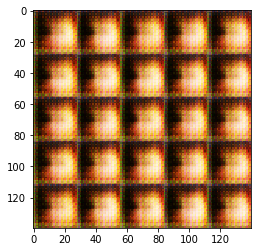

Epoch 1/1 Step 110... Discriminator Loss: 1.2164... Generator Loss: 1.3033
Epoch 1/1 Step 120... Discriminator Loss: 0.6557... Generator Loss: 1.7353
Epoch 1/1 Step 130... Discriminator Loss: 0.8604... Generator Loss: 1.5573
Epoch 1/1 Step 140... Discriminator Loss: 0.6364... Generator Loss: 1.8161
Epoch 1/1 Step 150... Discriminator Loss: 0.6226... Generator Loss: 2.3745
Epoch 1/1 Step 160... Discriminator Loss: 0.8441... Generator Loss: 2.1425
Epoch 1/1 Step 170... Discriminator Loss: 0.7897... Generator Loss: 1.4632
Epoch 1/1 Step 180... Discriminator Loss: 0.7934... Generator Loss: 1.8967
Epoch 1/1 Step 190... Discriminator Loss: 1.0040... Generator Loss: 2.5067
Epoch 1/1 Step 200... Discriminator Loss: 0.7859... Generator Loss: 1.3278


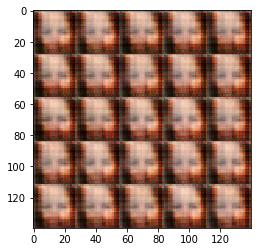

Epoch 1/1 Step 210... Discriminator Loss: 0.9923... Generator Loss: 1.3443
Epoch 1/1 Step 220... Discriminator Loss: 0.8302... Generator Loss: 1.4505
Epoch 1/1 Step 230... Discriminator Loss: 1.0474... Generator Loss: 1.0436
Epoch 1/1 Step 240... Discriminator Loss: 0.7675... Generator Loss: 1.3269
Epoch 1/1 Step 250... Discriminator Loss: 0.8967... Generator Loss: 1.1962
Epoch 1/1 Step 260... Discriminator Loss: 1.0902... Generator Loss: 1.4524
Epoch 1/1 Step 270... Discriminator Loss: 1.1671... Generator Loss: 1.1588
Epoch 1/1 Step 280... Discriminator Loss: 1.0952... Generator Loss: 0.8818
Epoch 1/1 Step 290... Discriminator Loss: 0.9136... Generator Loss: 1.0114
Epoch 1/1 Step 300... Discriminator Loss: 0.9857... Generator Loss: 1.4953


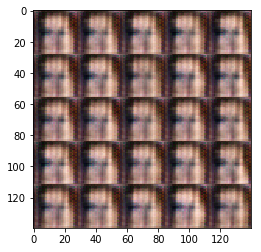

Epoch 1/1 Step 310... Discriminator Loss: 1.3309... Generator Loss: 0.8030
Epoch 1/1 Step 320... Discriminator Loss: 1.3973... Generator Loss: 0.6113
Epoch 1/1 Step 330... Discriminator Loss: 0.8552... Generator Loss: 1.2200
Epoch 1/1 Step 340... Discriminator Loss: 1.0783... Generator Loss: 1.2946
Epoch 1/1 Step 350... Discriminator Loss: 1.4668... Generator Loss: 0.9721
Epoch 1/1 Step 360... Discriminator Loss: 1.0025... Generator Loss: 1.1395
Epoch 1/1 Step 370... Discriminator Loss: 0.9037... Generator Loss: 1.5921
Epoch 1/1 Step 380... Discriminator Loss: 0.9683... Generator Loss: 1.2678
Epoch 1/1 Step 390... Discriminator Loss: 1.2556... Generator Loss: 0.6933
Epoch 1/1 Step 400... Discriminator Loss: 1.3400... Generator Loss: 1.0048


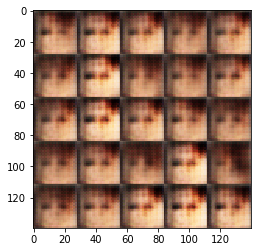

Epoch 1/1 Step 410... Discriminator Loss: 1.0977... Generator Loss: 1.0932
Epoch 1/1 Step 420... Discriminator Loss: 1.2130... Generator Loss: 0.9976
Epoch 1/1 Step 430... Discriminator Loss: 1.2452... Generator Loss: 0.9409
Epoch 1/1 Step 440... Discriminator Loss: 1.1269... Generator Loss: 1.1603
Epoch 1/1 Step 450... Discriminator Loss: 1.1048... Generator Loss: 0.9374
Epoch 1/1 Step 460... Discriminator Loss: 0.9352... Generator Loss: 1.2635
Epoch 1/1 Step 470... Discriminator Loss: 1.1796... Generator Loss: 1.1176
Epoch 1/1 Step 480... Discriminator Loss: 1.0414... Generator Loss: 1.2155
Epoch 1/1 Step 490... Discriminator Loss: 1.1164... Generator Loss: 1.2350
Epoch 1/1 Step 500... Discriminator Loss: 1.0497... Generator Loss: 1.2831


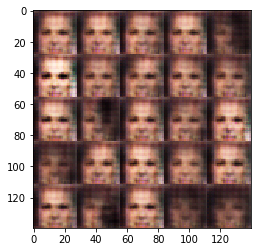

Epoch 1/1 Step 510... Discriminator Loss: 0.9436... Generator Loss: 1.3195
Epoch 1/1 Step 520... Discriminator Loss: 1.0598... Generator Loss: 1.3665
Epoch 1/1 Step 530... Discriminator Loss: 1.1168... Generator Loss: 1.4097
Epoch 1/1 Step 540... Discriminator Loss: 1.3316... Generator Loss: 1.3381
Epoch 1/1 Step 550... Discriminator Loss: 1.0232... Generator Loss: 1.1463
Epoch 1/1 Step 560... Discriminator Loss: 0.9716... Generator Loss: 1.2827
Epoch 1/1 Step 570... Discriminator Loss: 1.1476... Generator Loss: 1.0632
Epoch 1/1 Step 580... Discriminator Loss: 1.1149... Generator Loss: 1.0924
Epoch 1/1 Step 590... Discriminator Loss: 0.9377... Generator Loss: 1.2549
Epoch 1/1 Step 600... Discriminator Loss: 0.8410... Generator Loss: 1.3579


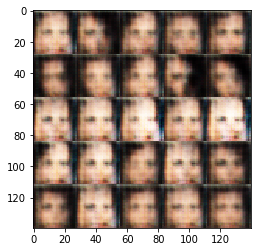

Epoch 1/1 Step 610... Discriminator Loss: 0.9827... Generator Loss: 1.2260
Epoch 1/1 Step 620... Discriminator Loss: 1.1978... Generator Loss: 0.9127
Epoch 1/1 Step 630... Discriminator Loss: 0.8438... Generator Loss: 1.4349
Epoch 1/1 Step 640... Discriminator Loss: 0.9228... Generator Loss: 1.2276
Epoch 1/1 Step 650... Discriminator Loss: 1.0957... Generator Loss: 0.9674
Epoch 1/1 Step 660... Discriminator Loss: 1.3715... Generator Loss: 0.8749
Epoch 1/1 Step 670... Discriminator Loss: 1.1011... Generator Loss: 1.0899
Epoch 1/1 Step 680... Discriminator Loss: 1.4351... Generator Loss: 1.7697
Epoch 1/1 Step 690... Discriminator Loss: 1.1669... Generator Loss: 1.1191
Epoch 1/1 Step 700... Discriminator Loss: 1.1407... Generator Loss: 0.9626


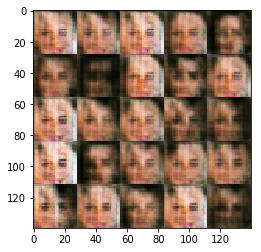

Epoch 1/1 Step 710... Discriminator Loss: 1.1297... Generator Loss: 0.9919
Epoch 1/1 Step 720... Discriminator Loss: 0.8562... Generator Loss: 1.4441
Epoch 1/1 Step 730... Discriminator Loss: 1.2255... Generator Loss: 0.8633
Epoch 1/1 Step 740... Discriminator Loss: 1.0140... Generator Loss: 1.0785
Epoch 1/1 Step 750... Discriminator Loss: 1.1385... Generator Loss: 1.0930
Epoch 1/1 Step 760... Discriminator Loss: 1.0479... Generator Loss: 1.2119
Epoch 1/1 Step 770... Discriminator Loss: 1.2810... Generator Loss: 0.8114
Epoch 1/1 Step 780... Discriminator Loss: 1.3999... Generator Loss: 0.8081
Epoch 1/1 Step 790... Discriminator Loss: 0.9954... Generator Loss: 1.0913
Epoch 1/1 Step 800... Discriminator Loss: 1.0328... Generator Loss: 1.1236


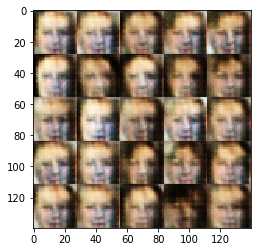

Epoch 1/1 Step 810... Discriminator Loss: 1.4631... Generator Loss: 0.9160
Epoch 1/1 Step 820... Discriminator Loss: 1.2105... Generator Loss: 0.9525
Epoch 1/1 Step 830... Discriminator Loss: 1.0939... Generator Loss: 1.0626
Epoch 1/1 Step 840... Discriminator Loss: 1.1941... Generator Loss: 0.9731
Epoch 1/1 Step 850... Discriminator Loss: 1.2540... Generator Loss: 0.9629
Epoch 1/1 Step 860... Discriminator Loss: 1.2205... Generator Loss: 0.9789
Epoch 1/1 Step 870... Discriminator Loss: 1.3687... Generator Loss: 0.8293
Epoch 1/1 Step 880... Discriminator Loss: 1.4081... Generator Loss: 0.6119
Epoch 1/1 Step 890... Discriminator Loss: 1.2686... Generator Loss: 0.9554
Epoch 1/1 Step 900... Discriminator Loss: 1.2074... Generator Loss: 0.9831


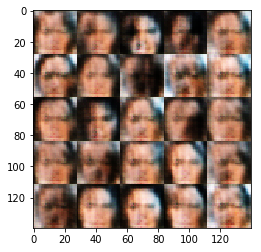

Epoch 1/1 Step 910... Discriminator Loss: 1.2182... Generator Loss: 0.9753
Epoch 1/1 Step 920... Discriminator Loss: 1.2466... Generator Loss: 0.9139
Epoch 1/1 Step 930... Discriminator Loss: 1.4349... Generator Loss: 0.8201
Epoch 1/1 Step 940... Discriminator Loss: 1.1531... Generator Loss: 0.9302
Epoch 1/1 Step 950... Discriminator Loss: 1.1979... Generator Loss: 0.9504
Epoch 1/1 Step 960... Discriminator Loss: 1.2089... Generator Loss: 0.9400
Epoch 1/1 Step 970... Discriminator Loss: 1.2736... Generator Loss: 0.9079
Epoch 1/1 Step 980... Discriminator Loss: 1.2024... Generator Loss: 0.9266
Epoch 1/1 Step 990... Discriminator Loss: 1.2679... Generator Loss: 0.9277
Epoch 1/1 Step 1000... Discriminator Loss: 1.5124... Generator Loss: 0.6716


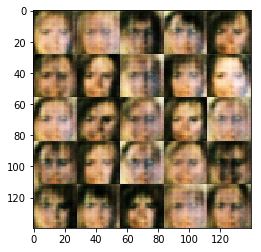

Epoch 1/1 Step 1010... Discriminator Loss: 1.3388... Generator Loss: 0.8402
Epoch 1/1 Step 1020... Discriminator Loss: 1.2933... Generator Loss: 0.8638
Epoch 1/1 Step 1030... Discriminator Loss: 1.3404... Generator Loss: 0.8900
Epoch 1/1 Step 1040... Discriminator Loss: 1.2643... Generator Loss: 0.9928
Epoch 1/1 Step 1050... Discriminator Loss: 1.0944... Generator Loss: 1.0511
Epoch 1/1 Step 1060... Discriminator Loss: 1.2442... Generator Loss: 0.9050
Epoch 1/1 Step 1070... Discriminator Loss: 1.4615... Generator Loss: 0.6161
Epoch 1/1 Step 1080... Discriminator Loss: 1.3600... Generator Loss: 0.8153
Epoch 1/1 Step 1090... Discriminator Loss: 1.2889... Generator Loss: 0.8568
Epoch 1/1 Step 1100... Discriminator Loss: 1.2965... Generator Loss: 0.8975


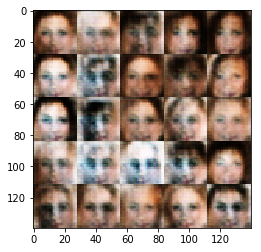

Epoch 1/1 Step 1110... Discriminator Loss: 1.2403... Generator Loss: 0.9175
Epoch 1/1 Step 1120... Discriminator Loss: 1.1919... Generator Loss: 0.9891
Epoch 1/1 Step 1130... Discriminator Loss: 1.2344... Generator Loss: 0.9184
Epoch 1/1 Step 1140... Discriminator Loss: 1.1877... Generator Loss: 0.9095
Epoch 1/1 Step 1150... Discriminator Loss: 1.3223... Generator Loss: 0.8793
Epoch 1/1 Step 1160... Discriminator Loss: 1.2144... Generator Loss: 0.9659
Epoch 1/1 Step 1170... Discriminator Loss: 1.2813... Generator Loss: 0.8865
Epoch 1/1 Step 1180... Discriminator Loss: 1.3492... Generator Loss: 0.8701
Epoch 1/1 Step 1190... Discriminator Loss: 1.2831... Generator Loss: 0.8515
Epoch 1/1 Step 1200... Discriminator Loss: 1.3274... Generator Loss: 0.9188


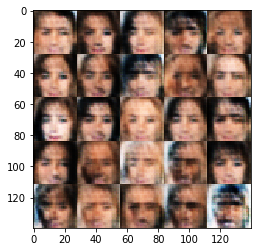

Epoch 1/1 Step 1210... Discriminator Loss: 1.2326... Generator Loss: 0.8728
Epoch 1/1 Step 1220... Discriminator Loss: 1.3130... Generator Loss: 0.8501
Epoch 1/1 Step 1230... Discriminator Loss: 1.2268... Generator Loss: 0.9261
Epoch 1/1 Step 1240... Discriminator Loss: 1.3196... Generator Loss: 0.8490
Epoch 1/1 Step 1250... Discriminator Loss: 1.3112... Generator Loss: 0.9161
Epoch 1/1 Step 1260... Discriminator Loss: 1.3162... Generator Loss: 0.8013
Epoch 1/1 Step 1270... Discriminator Loss: 1.2692... Generator Loss: 0.8660
Epoch 1/1 Step 1280... Discriminator Loss: 1.3600... Generator Loss: 0.7705
Epoch 1/1 Step 1290... Discriminator Loss: 1.2182... Generator Loss: 0.9913
Epoch 1/1 Step 1300... Discriminator Loss: 1.3615... Generator Loss: 0.8459


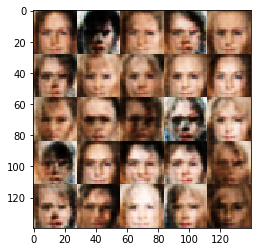

Epoch 1/1 Step 1310... Discriminator Loss: 1.2586... Generator Loss: 0.9633
Epoch 1/1 Step 1320... Discriminator Loss: 1.4514... Generator Loss: 0.7909
Epoch 1/1 Step 1330... Discriminator Loss: 1.2384... Generator Loss: 0.9520
Epoch 1/1 Step 1340... Discriminator Loss: 1.3261... Generator Loss: 0.8321
Epoch 1/1 Step 1350... Discriminator Loss: 1.2829... Generator Loss: 0.8734
Epoch 1/1 Step 1360... Discriminator Loss: 1.3722... Generator Loss: 0.7664
Epoch 1/1 Step 1370... Discriminator Loss: 1.2595... Generator Loss: 0.9310
Epoch 1/1 Step 1380... Discriminator Loss: 1.4562... Generator Loss: 0.8227
Epoch 1/1 Step 1390... Discriminator Loss: 1.3693... Generator Loss: 0.8304
Epoch 1/1 Step 1400... Discriminator Loss: 1.3323... Generator Loss: 0.7942


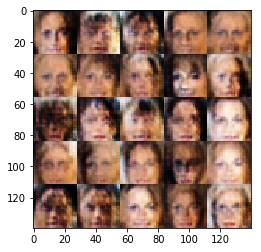

Epoch 1/1 Step 1410... Discriminator Loss: 1.3392... Generator Loss: 0.7723
Epoch 1/1 Step 1420... Discriminator Loss: 1.3532... Generator Loss: 0.9296
Epoch 1/1 Step 1430... Discriminator Loss: 1.1952... Generator Loss: 0.9473
Epoch 1/1 Step 1440... Discriminator Loss: 1.3332... Generator Loss: 0.8431
Epoch 1/1 Step 1450... Discriminator Loss: 1.2542... Generator Loss: 0.9724
Epoch 1/1 Step 1460... Discriminator Loss: 1.2555... Generator Loss: 0.9741
Epoch 1/1 Step 1470... Discriminator Loss: 1.2394... Generator Loss: 0.8524
Epoch 1/1 Step 1480... Discriminator Loss: 1.2315... Generator Loss: 0.8489
Epoch 1/1 Step 1490... Discriminator Loss: 1.2507... Generator Loss: 0.8976
Epoch 1/1 Step 1500... Discriminator Loss: 1.2816... Generator Loss: 0.8757


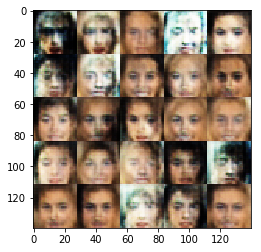

Epoch 1/1 Step 1510... Discriminator Loss: 1.2103... Generator Loss: 0.9402
Epoch 1/1 Step 1520... Discriminator Loss: 1.1831... Generator Loss: 0.9088
Epoch 1/1 Step 1530... Discriminator Loss: 1.3482... Generator Loss: 0.8542
Epoch 1/1 Step 1540... Discriminator Loss: 1.2152... Generator Loss: 0.8460
Epoch 1/1 Step 1550... Discriminator Loss: 1.3203... Generator Loss: 0.8929
Epoch 1/1 Step 1560... Discriminator Loss: 1.2590... Generator Loss: 0.8525
Epoch 1/1 Step 1570... Discriminator Loss: 1.1914... Generator Loss: 0.9716
Epoch 1/1 Step 1580... Discriminator Loss: 1.2383... Generator Loss: 0.9613
Epoch 1/1 Step 1590... Discriminator Loss: 1.3581... Generator Loss: 0.8118
Epoch 1/1 Step 1600... Discriminator Loss: 1.2230... Generator Loss: 1.0151


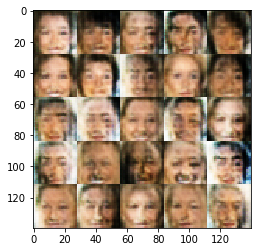

Epoch 1/1 Step 1610... Discriminator Loss: 1.2895... Generator Loss: 0.9529
Epoch 1/1 Step 1620... Discriminator Loss: 1.2692... Generator Loss: 0.9522
Epoch 1/1 Step 1630... Discriminator Loss: 1.3056... Generator Loss: 0.9498
Epoch 1/1 Step 1640... Discriminator Loss: 1.3241... Generator Loss: 0.8124
Epoch 1/1 Step 1650... Discriminator Loss: 1.3169... Generator Loss: 0.8940
Epoch 1/1 Step 1660... Discriminator Loss: 1.1827... Generator Loss: 0.8359
Epoch 1/1 Step 1670... Discriminator Loss: 1.3125... Generator Loss: 0.9830
Epoch 1/1 Step 1680... Discriminator Loss: 1.2833... Generator Loss: 0.8886
Epoch 1/1 Step 1690... Discriminator Loss: 1.1912... Generator Loss: 0.9081
Epoch 1/1 Step 1700... Discriminator Loss: 1.4000... Generator Loss: 0.9463


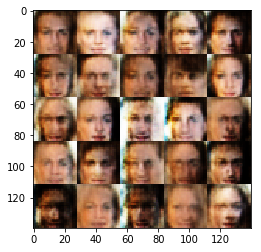

Epoch 1/1 Step 1710... Discriminator Loss: 1.3651... Generator Loss: 0.9171
Epoch 1/1 Step 1720... Discriminator Loss: 1.3685... Generator Loss: 0.9819
Epoch 1/1 Step 1730... Discriminator Loss: 1.2335... Generator Loss: 0.8187
Epoch 1/1 Step 1740... Discriminator Loss: 1.3015... Generator Loss: 1.1337
Epoch 1/1 Step 1750... Discriminator Loss: 1.1935... Generator Loss: 0.8961
Epoch 1/1 Step 1760... Discriminator Loss: 1.2949... Generator Loss: 0.9315
Epoch 1/1 Step 1770... Discriminator Loss: 1.2660... Generator Loss: 1.0003
Epoch 1/1 Step 1780... Discriminator Loss: 1.3147... Generator Loss: 0.8671
Epoch 1/1 Step 1790... Discriminator Loss: 1.2237... Generator Loss: 0.8751
Epoch 1/1 Step 1800... Discriminator Loss: 1.2628... Generator Loss: 0.8613


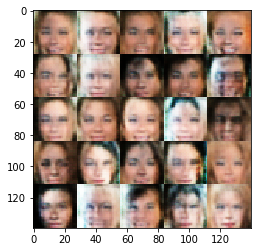

Epoch 1/1 Step 1810... Discriminator Loss: 1.3338... Generator Loss: 0.8995
Epoch 1/1 Step 1820... Discriminator Loss: 1.2583... Generator Loss: 0.9592
Epoch 1/1 Step 1830... Discriminator Loss: 1.1613... Generator Loss: 0.9815
Epoch 1/1 Step 1840... Discriminator Loss: 1.3104... Generator Loss: 0.8879
Epoch 1/1 Step 1850... Discriminator Loss: 1.2239... Generator Loss: 0.9465
Epoch 1/1 Step 1860... Discriminator Loss: 1.3447... Generator Loss: 0.9199
Epoch 1/1 Step 1870... Discriminator Loss: 1.2658... Generator Loss: 0.8833
Epoch 1/1 Step 1880... Discriminator Loss: 1.3205... Generator Loss: 0.8936
Epoch 1/1 Step 1890... Discriminator Loss: 1.2395... Generator Loss: 0.8944
Epoch 1/1 Step 1900... Discriminator Loss: 1.3185... Generator Loss: 0.8002


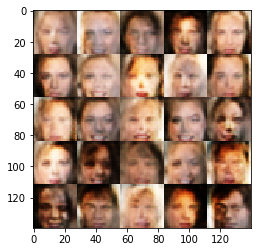

Epoch 1/1 Step 1910... Discriminator Loss: 1.1806... Generator Loss: 0.8772
Epoch 1/1 Step 1920... Discriminator Loss: 1.2622... Generator Loss: 0.9697
Epoch 1/1 Step 1930... Discriminator Loss: 1.3722... Generator Loss: 0.8770
Epoch 1/1 Step 1940... Discriminator Loss: 1.2872... Generator Loss: 0.8463
Epoch 1/1 Step 1950... Discriminator Loss: 1.3369... Generator Loss: 0.8414
Epoch 1/1 Step 1960... Discriminator Loss: 1.3121... Generator Loss: 0.9786
Epoch 1/1 Step 1970... Discriminator Loss: 1.3131... Generator Loss: 0.9226
Epoch 1/1 Step 1980... Discriminator Loss: 1.1927... Generator Loss: 0.9848
Epoch 1/1 Step 1990... Discriminator Loss: 1.3156... Generator Loss: 0.8322
Epoch 1/1 Step 2000... Discriminator Loss: 1.2278... Generator Loss: 0.9830


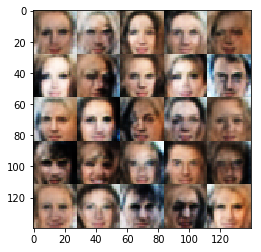

Epoch 1/1 Step 2010... Discriminator Loss: 1.3110... Generator Loss: 0.9718
Epoch 1/1 Step 2020... Discriminator Loss: 1.1931... Generator Loss: 0.9451
Epoch 1/1 Step 2030... Discriminator Loss: 1.3129... Generator Loss: 0.8597
Epoch 1/1 Step 2040... Discriminator Loss: 1.2311... Generator Loss: 0.8633
Epoch 1/1 Step 2050... Discriminator Loss: 1.1834... Generator Loss: 0.9799
Epoch 1/1 Step 2060... Discriminator Loss: 1.3249... Generator Loss: 0.8558
Epoch 1/1 Step 2070... Discriminator Loss: 1.3594... Generator Loss: 0.8531
Epoch 1/1 Step 2080... Discriminator Loss: 1.3421... Generator Loss: 0.9192
Epoch 1/1 Step 2090... Discriminator Loss: 1.3145... Generator Loss: 0.8786
Epoch 1/1 Step 2100... Discriminator Loss: 1.3520... Generator Loss: 0.8524


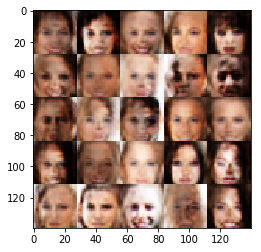

Epoch 1/1 Step 2110... Discriminator Loss: 1.3072... Generator Loss: 0.8514
Epoch 1/1 Step 2120... Discriminator Loss: 1.3000... Generator Loss: 0.9255
Epoch 1/1 Step 2130... Discriminator Loss: 1.3056... Generator Loss: 0.8748
Epoch 1/1 Step 2140... Discriminator Loss: 1.2887... Generator Loss: 0.9470
Epoch 1/1 Step 2150... Discriminator Loss: 1.2169... Generator Loss: 1.0020
Epoch 1/1 Step 2160... Discriminator Loss: 1.1951... Generator Loss: 0.9182
Epoch 1/1 Step 2170... Discriminator Loss: 1.2333... Generator Loss: 1.0957
Epoch 1/1 Step 2180... Discriminator Loss: 1.2141... Generator Loss: 0.8232
Epoch 1/1 Step 2190... Discriminator Loss: 1.3080... Generator Loss: 1.0119
Epoch 1/1 Step 2200... Discriminator Loss: 1.2547... Generator Loss: 0.9168


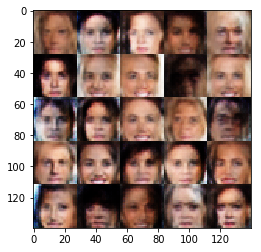

Epoch 1/1 Step 2210... Discriminator Loss: 1.2376... Generator Loss: 0.8688
Epoch 1/1 Step 2220... Discriminator Loss: 1.2269... Generator Loss: 1.0456
Epoch 1/1 Step 2230... Discriminator Loss: 1.2745... Generator Loss: 0.8568
Epoch 1/1 Step 2240... Discriminator Loss: 1.1823... Generator Loss: 1.0829
Epoch 1/1 Step 2250... Discriminator Loss: 1.1820... Generator Loss: 1.0464
Epoch 1/1 Step 2260... Discriminator Loss: 1.3379... Generator Loss: 0.8111
Epoch 1/1 Step 2270... Discriminator Loss: 1.2437... Generator Loss: 0.8382
Epoch 1/1 Step 2280... Discriminator Loss: 1.2876... Generator Loss: 0.8606
Epoch 1/1 Step 2290... Discriminator Loss: 1.3566... Generator Loss: 0.8598
Epoch 1/1 Step 2300... Discriminator Loss: 1.2450... Generator Loss: 0.8517


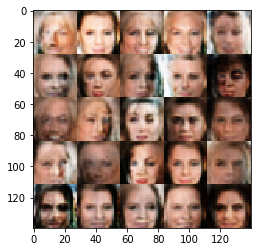

Epoch 1/1 Step 2310... Discriminator Loss: 1.3203... Generator Loss: 0.9015
Epoch 1/1 Step 2320... Discriminator Loss: 1.2204... Generator Loss: 0.9309
Epoch 1/1 Step 2330... Discriminator Loss: 1.3061... Generator Loss: 0.8788
Epoch 1/1 Step 2340... Discriminator Loss: 1.2441... Generator Loss: 0.8183
Epoch 1/1 Step 2350... Discriminator Loss: 1.1913... Generator Loss: 1.1924
Epoch 1/1 Step 2360... Discriminator Loss: 1.2642... Generator Loss: 0.8533
Epoch 1/1 Step 2370... Discriminator Loss: 1.2420... Generator Loss: 0.8720
Epoch 1/1 Step 2380... Discriminator Loss: 1.2320... Generator Loss: 0.8442
Epoch 1/1 Step 2390... Discriminator Loss: 1.3482... Generator Loss: 0.7842
Epoch 1/1 Step 2400... Discriminator Loss: 1.2322... Generator Loss: 0.7789


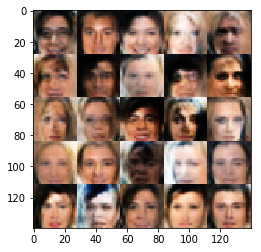

Epoch 1/1 Step 2410... Discriminator Loss: 1.3463... Generator Loss: 1.1030
Epoch 1/1 Step 2420... Discriminator Loss: 1.3113... Generator Loss: 0.8864
Epoch 1/1 Step 2430... Discriminator Loss: 1.3211... Generator Loss: 0.8143
Epoch 1/1 Step 2440... Discriminator Loss: 1.2209... Generator Loss: 0.8687
Epoch 1/1 Step 2450... Discriminator Loss: 1.2589... Generator Loss: 0.8560
Epoch 1/1 Step 2460... Discriminator Loss: 1.2340... Generator Loss: 0.9571
Epoch 1/1 Step 2470... Discriminator Loss: 1.2265... Generator Loss: 0.9154
Epoch 1/1 Step 2480... Discriminator Loss: 1.2878... Generator Loss: 1.0082
Epoch 1/1 Step 2490... Discriminator Loss: 1.3153... Generator Loss: 0.8937
Epoch 1/1 Step 2500... Discriminator Loss: 1.2765... Generator Loss: 0.8070


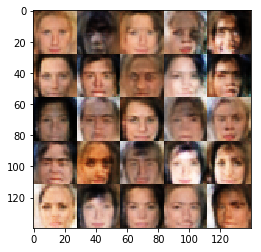

Epoch 1/1 Step 2510... Discriminator Loss: 1.2976... Generator Loss: 0.7901
Epoch 1/1 Step 2520... Discriminator Loss: 1.3145... Generator Loss: 0.9627
Epoch 1/1 Step 2530... Discriminator Loss: 1.2367... Generator Loss: 0.8962
Epoch 1/1 Step 2540... Discriminator Loss: 1.3234... Generator Loss: 0.7225
Epoch 1/1 Step 2550... Discriminator Loss: 1.2035... Generator Loss: 0.8189
Epoch 1/1 Step 2560... Discriminator Loss: 1.1539... Generator Loss: 0.9806
Epoch 1/1 Step 2570... Discriminator Loss: 1.1924... Generator Loss: 0.9337
Epoch 1/1 Step 2580... Discriminator Loss: 1.1695... Generator Loss: 0.9207
Epoch 1/1 Step 2590... Discriminator Loss: 1.1744... Generator Loss: 0.9908
Epoch 1/1 Step 2600... Discriminator Loss: 1.3099... Generator Loss: 0.8277


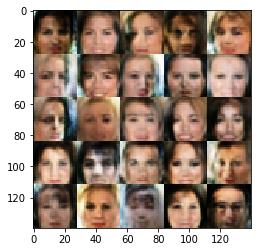

Epoch 1/1 Step 2610... Discriminator Loss: 1.2606... Generator Loss: 0.8895
Epoch 1/1 Step 2620... Discriminator Loss: 1.2807... Generator Loss: 0.9089
Epoch 1/1 Step 2630... Discriminator Loss: 1.3345... Generator Loss: 0.9334
Epoch 1/1 Step 2640... Discriminator Loss: 1.2186... Generator Loss: 0.8774
Epoch 1/1 Step 2650... Discriminator Loss: 1.2342... Generator Loss: 0.9948
Epoch 1/1 Step 2660... Discriminator Loss: 1.1997... Generator Loss: 0.9304
Epoch 1/1 Step 2670... Discriminator Loss: 1.2240... Generator Loss: 0.8607
Epoch 1/1 Step 2680... Discriminator Loss: 1.1935... Generator Loss: 1.0248
Epoch 1/1 Step 2690... Discriminator Loss: 1.2394... Generator Loss: 0.9873
Epoch 1/1 Step 2700... Discriminator Loss: 1.2524... Generator Loss: 0.7501


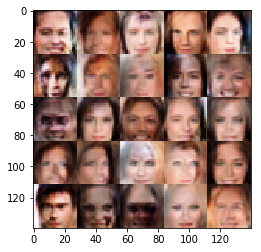

Epoch 1/1 Step 2710... Discriminator Loss: 1.2457... Generator Loss: 0.9330
Epoch 1/1 Step 2720... Discriminator Loss: 1.2474... Generator Loss: 0.8811
Epoch 1/1 Step 2730... Discriminator Loss: 1.2288... Generator Loss: 0.9797
Epoch 1/1 Step 2740... Discriminator Loss: 1.2391... Generator Loss: 0.8512
Epoch 1/1 Step 2750... Discriminator Loss: 1.2185... Generator Loss: 0.9046
Epoch 1/1 Step 2760... Discriminator Loss: 1.3194... Generator Loss: 1.1482
Epoch 1/1 Step 2770... Discriminator Loss: 1.2647... Generator Loss: 0.8475
Epoch 1/1 Step 2780... Discriminator Loss: 1.3253... Generator Loss: 1.0081
Epoch 1/1 Step 2790... Discriminator Loss: 1.3284... Generator Loss: 0.9731
Epoch 1/1 Step 2800... Discriminator Loss: 1.3027... Generator Loss: 1.0066


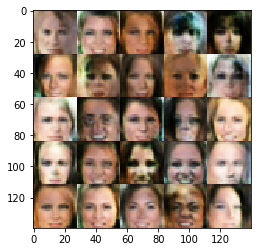

Epoch 1/1 Step 2810... Discriminator Loss: 1.2378... Generator Loss: 0.8529
Epoch 1/1 Step 2820... Discriminator Loss: 1.2738... Generator Loss: 1.1321
Epoch 1/1 Step 2830... Discriminator Loss: 1.1903... Generator Loss: 1.0802
Epoch 1/1 Step 2840... Discriminator Loss: 1.2337... Generator Loss: 0.8742
Epoch 1/1 Step 2850... Discriminator Loss: 1.3445... Generator Loss: 0.7539
Epoch 1/1 Step 2860... Discriminator Loss: 1.2548... Generator Loss: 0.9122
Epoch 1/1 Step 2870... Discriminator Loss: 1.2611... Generator Loss: 0.8623
Epoch 1/1 Step 2880... Discriminator Loss: 1.3138... Generator Loss: 0.7388
Epoch 1/1 Step 2890... Discriminator Loss: 1.2270... Generator Loss: 0.7878
Epoch 1/1 Step 2900... Discriminator Loss: 1.2875... Generator Loss: 0.9383


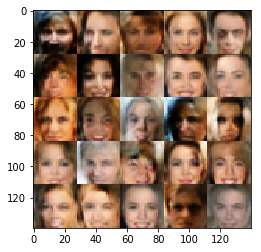

Epoch 1/1 Step 2910... Discriminator Loss: 1.1776... Generator Loss: 0.8973
Epoch 1/1 Step 2920... Discriminator Loss: 1.2267... Generator Loss: 0.8615
Epoch 1/1 Step 2930... Discriminator Loss: 1.2709... Generator Loss: 1.0457
Epoch 1/1 Step 2940... Discriminator Loss: 1.1884... Generator Loss: 1.0472
Epoch 1/1 Step 2950... Discriminator Loss: 1.2368... Generator Loss: 1.1889
Epoch 1/1 Step 2960... Discriminator Loss: 1.2937... Generator Loss: 0.8199
Epoch 1/1 Step 2970... Discriminator Loss: 1.2720... Generator Loss: 1.0777
Epoch 1/1 Step 2980... Discriminator Loss: 1.2937... Generator Loss: 0.8844
Epoch 1/1 Step 2990... Discriminator Loss: 1.2471... Generator Loss: 0.8309
Epoch 1/1 Step 3000... Discriminator Loss: 1.1893... Generator Loss: 0.8754


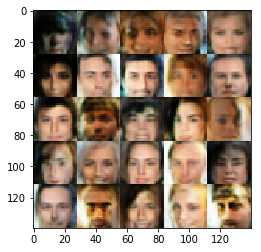

Epoch 1/1 Step 3010... Discriminator Loss: 1.2976... Generator Loss: 1.1603
Epoch 1/1 Step 3020... Discriminator Loss: 1.2290... Generator Loss: 0.8298
Epoch 1/1 Step 3030... Discriminator Loss: 1.2700... Generator Loss: 0.9263
Epoch 1/1 Step 3040... Discriminator Loss: 1.2020... Generator Loss: 0.9727
Epoch 1/1 Step 3050... Discriminator Loss: 1.1775... Generator Loss: 0.9641
Epoch 1/1 Step 3060... Discriminator Loss: 1.2869... Generator Loss: 0.8641
Epoch 1/1 Step 3070... Discriminator Loss: 1.2373... Generator Loss: 0.8443
Epoch 1/1 Step 3080... Discriminator Loss: 1.2704... Generator Loss: 0.9682
Epoch 1/1 Step 3090... Discriminator Loss: 1.2054... Generator Loss: 1.0179
Epoch 1/1 Step 3100... Discriminator Loss: 1.2684... Generator Loss: 0.9440


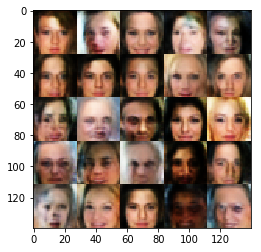

Epoch 1/1 Step 3110... Discriminator Loss: 1.2617... Generator Loss: 0.7455
Epoch 1/1 Step 3120... Discriminator Loss: 1.3192... Generator Loss: 0.7933
Epoch 1/1 Step 3130... Discriminator Loss: 1.2352... Generator Loss: 0.8439
Epoch 1/1 Step 3140... Discriminator Loss: 1.2679... Generator Loss: 0.9206
Epoch 1/1 Step 3150... Discriminator Loss: 1.2087... Generator Loss: 0.9003
Epoch 1/1 Step 3160... Discriminator Loss: 1.2562... Generator Loss: 0.8847


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.00025
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)